# Exercise 9: Geometry Constrained Feature Matching

## Helper functions


In [81]:
import numpy as np
import cv2 
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib
import skimage

def load_im(path : str) -> np.ndarray:
    """
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    return im


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom


def hest(q1, q2) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x)) # <-- formula follows that of week 2, slide 56
        # print(np.kron(q2t_hom.T, q1x).shape)
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    
def crossOp(p : np.ndarray) -> np.ndarray:
    """
        One of Them weird functions. It takes in a 3D vector and then returns
        some gnarly matrix.
    """
    p = p.flatten()
    if p.size != 3:
        raise Exception("Invalid input, vector must be exactly 3D.")
    
    x, y, z = p
    px = np.array(
        [[0, -z, y],
         [z, 0, -x],
         [-y, x, 0]]
    )
    
    return px


def computeFundamentalMatrix(K1 : np.ndarray, K2 : np.ndarray, R2 : np.ndarray, t2 : np.ndarray) -> np.ndarray:
    """
        Computing the fundamental matrix between two camera matrices K1 & K2.
    """
    t2x = crossOp(t2)

    E = t2x @ R2

    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)

    F = K1inv.T @ E @ K2inv
    
    return F


def fancyRotate(theta_x, theta_y, theta_z):
    """
        Does the rotation matrix that we have seen a few times.
        E.g. Exercises week 4, eq(12).
    """
    from scipy.spatial.transform import Rotation
    
    R = Rotation.from_euler("xyz", [theta_x, theta_y, theta_z]).as_matrix()
    
    return R


def in_frame(l, l_im, shape):
    """
        I think this checks whether the line is within the image
    """
    q = np.cross(l.flatten(), l_im)
    q = q[:2]/q[2]
    if all(q >= 0) and all(q+1 <= shape[1::-1]):
        return q
    
    
def DrawLine(l, shape):
    """
        Checks where the line intersects the four sides of the image
        and finds the two intersections that are within the frame
    """
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l, l_im, shape) for l_im in lines if in_frame(l, l_im, shape) is not None]
    plt.plot(*np.array(P).T)


def draw_line_Vitus(line: np.ndarray, tau: float):
    """
        Draws a line with a width of tau.
        
        Takes:
            :param line: The line to be drawn
            :param tau: The distance from the line to be drawn
        
        Returns:
            :return: None
    """
    
    x1, x2 = plt.gca().get_xlim()
    y1 = -(line[0]*x1 + line[2]) / line[1]
    y2 = -(line[0]*x2 + line[2]) / line[1]
    y1_low = -(line[0]*x1 + line[2] + tau) / line[1]
    y1_high = -(line[0]*x1 + line[2] - tau) / line[1]
    y2_low = -(line[0]*x2 + line[2] + tau) / line[1]
    y2_high = -(line[0]*x2 + line[2] - tau) / line[1]
    
    plt.axline((x1,y1), (x2,y2), c='black')
    plt.axline((x1,y1_low), (x2,y2_low), c='black', linestyle='dashed')
    plt.axline((x1,y1_high), (x2,y2_high), c='black', linestyle='dashed')
    



## Ex 9.1

Implement a function `Fest_8point` that estimates a fundamental matrix from eight or more point correspondences, using the linear algorithm.

Test your function using the points in **Fest_test.npy**. Check that your estimated fundamental matrix is identical to `Ftrue` up to scale and numerical error.

### Response

In [82]:
PATH_FEST_TEST = "../Data/Week_09/Fest_test.npy"
test_points = np.load(PATH_FEST_TEST, allow_pickle=True).item()
q1 = test_points["q1"]
q2 = test_points["q2"]
F_true = test_points["Ftrue"]
print(f"q1 shape: {q1.shape}")
print(f"q2 shape: {q2.shape}")


def fest_8point(q1_points : np.ndarray, q2_points : np.ndarray) -> np.ndarray:
    """
        Takes:
            :param q1_points: A numpy array of the eight q1 points
            :param q2_points: A numpy array of the eight q2 points
        
        Returns:
            :return: A numpy array of the fundamental matrix  
    """
    
    n = q1_points.shape[1]  # <-- should very much be 8
    
    B = []
    for i in range(n):
        q1i = q1_points[:, i].reshape(-1, 1)
        q2i = q2_points[:, i].reshape(-1, 1)
        
        Bi = (q2i @ q1i.T).flatten()
        
        B.append(Bi)
    
    B = np.vstack(B)
    # print(f"Shape after concat: {B.shape}")
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ft = Vt[-1, :]
    
    F = np.reshape(Ft, (3, 3))
    
    return F

F = fest_8point(q1, q2)
F_scaled = F * (F_true[0,0] / F[0, 0])

print(f"F: \n{F}")
print(f"F_true: \n{F_true}")
print(f"F scaled: \n{F_scaled}")

print(f"\nTheir difference (scaled): \n{F_true - F_scaled}")

q1 shape: (3, 8)
q2 shape: (3, 8)
F: 
[[-3.07914555e-08  3.61883689e-06 -5.43583727e-04]
 [ 4.49876682e-06  2.24402704e-08 -1.51520136e-01]
 [-1.95223414e-03  1.48295604e-01  9.77264527e-01]]
F_true: 
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]
F scaled: 
[[ 6.67972386e-12 -7.85049968e-10  1.17921973e-07]
 [-9.75936981e-10 -4.86806511e-12  3.28699197e-05]
 [ 4.23506611e-07 -3.21704080e-05 -2.12002229e-04]]

Their difference (scaled): 
[[ 0.00000000e+00  1.03737155e-18 -1.85934704e-16]
 [ 1.14445463e-18  4.96225003e-21 -4.02778058e-14]
 [-4.92503125e-16  3.94197885e-14  2.60355078e-13]]


## Ex 9.2
As you did last week (I had covid... ;_; (but Anne came in clutch! B) )), find features in both images and match them. However, this time do not filter matches by the ratio test, only use cross checking as done by `cv2.BFMatcher_create(crossCheck = True)`.

Visualize the result and confirm that it looks reasonable compared to your expectations.

### Response

In [83]:
PATH_TWO_IMS = "../Data/Week_09/TwoImageData.npy"
stuff = np.load(PATH_TWO_IMS, allow_pickle=True).item()

im1 = stuff["im1"]
im2 = stuff["im2"]
R1 = stuff["R1"]
R2 = stuff["R2"]
t1 = stuff["t1"]
t2 = stuff["t2"]
K = stuff["K"]

print(f"R1: \n{R1} \n\nR2: \n{R2} \n\nt1: \n{t1} \n\nt2: \n{t2}")

R1: 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 

R2: 
[[ 9.97063888e-01  1.21564307e-04  7.65740684e-02]
 [-1.37753401e-04  9.99999969e-01  2.06135565e-04]
 [-7.65740409e-02 -2.16078666e-04  9.97063874e-01]] 

t1: 
[[0.]
 [0.]
 [0.]] 

t2: 
[[-0.04594547]
 [-0.00017171]
 [ 0.00157051]]


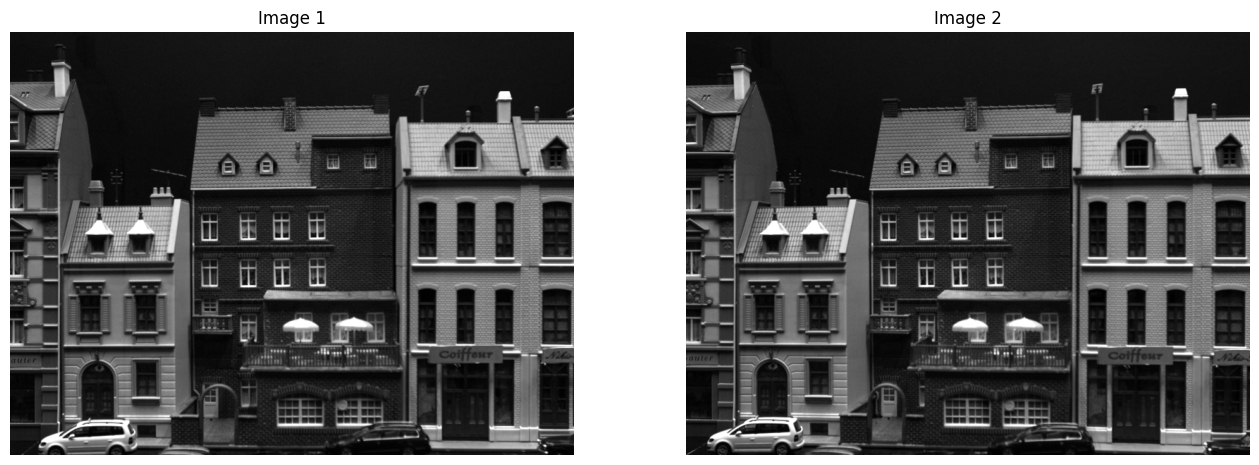

In [84]:
plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.title("Image 1")
plt.axis("off")
plt.imshow(im1, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Image 2")
plt.axis("off")
plt.imshow(im2, cmap="gray")

plt.show()

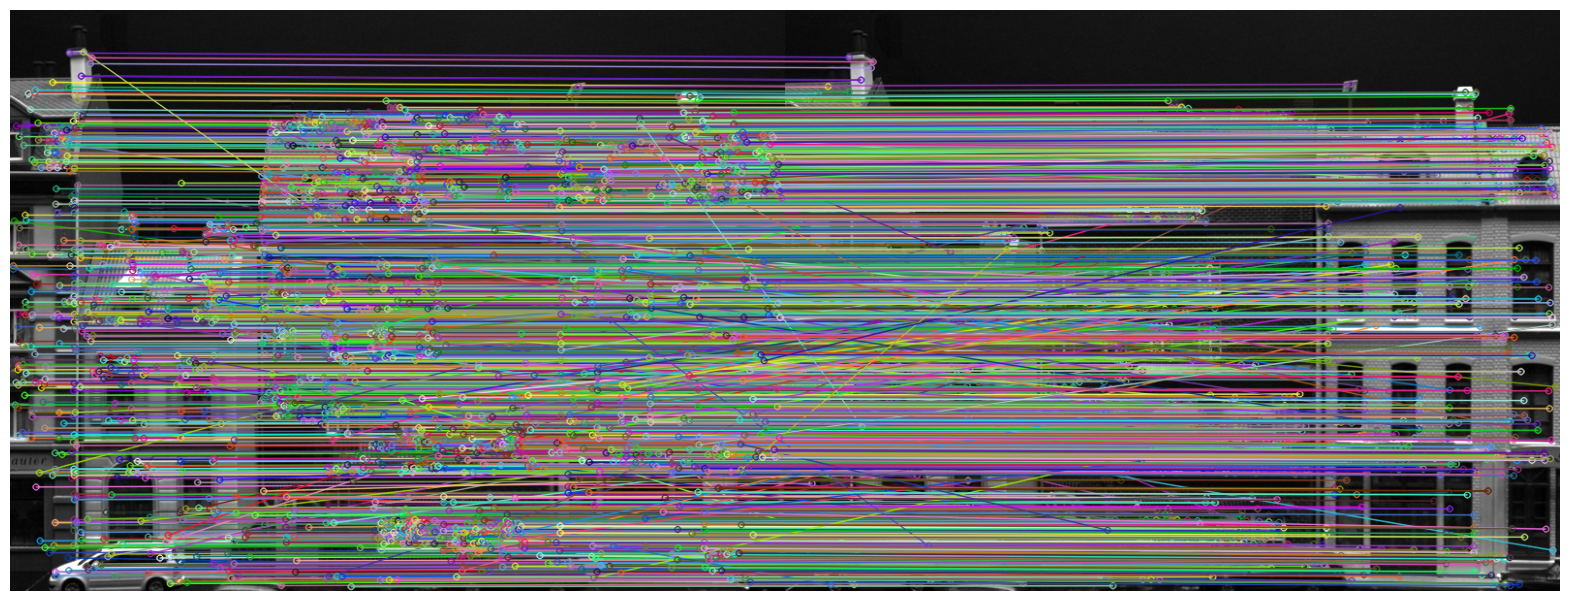

In [85]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

# BFMatcher with default params
bf = cv2.BFMatcher_create(crossCheck = True)

matches = bf.knnMatch(des1, des2, k=1)  # <-- k = 2 gives bugs

im_sift = cv2.drawMatchesKnn(im1, kp1, im2, kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)[:,:,::-1]

fig = plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(im_sift)
plt.show()


Just copied what Alex and the gang did...

## Ex 9.3 

Sample eight random matches. This can be done with the following code: `np.random.choice(matches, 8, replace=False)`.

Use your function `fest_8point` to estimate the fundamental matrix from these eight matches.

Write a function `SampsonsDistance(F, p1, p2)` that computes Sampsons's distance.

Set points to inliers if their Sampson’s distance is less than $3.84 · 3^2$. Explain where this value
comes from.

Repeat the above steps for the a fixed number of iterations, such as $200$.

Finally, use `fest_8point` to estimate the final fundamental matrix using all inliers of the best
model.

Run your algorithm on the the images from **TwoImageData.npy**. Compare your estimated **F** to
**Ftrue**. You could use the following code to compare them:

`(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))`.

Explain what this code does...


### Response

In [86]:
def sampsons_distance(F : np.ndarray, p1 : np.ndarray, p2 : np.ndarray) -> float:
    """
        Takes:
            :param F: The fundamental matrix
            :param p1: Point from image 1
            :param p2: Same point in image 2
        
        Returns:
            :return: The sampsons distance between the two points (p1, p2)
    """
    
    Fq1 = F @ p1
    q2tF = p2.T @ F 
    samps_dist = (p2.T @ F @ p1)**2 / (q2tF[0]**2 + q2tF[1]**2 + Fq1[0]**2 + Fq1[1]**2)
    
    return samps_dist


def RANSAC_F(N : int, p1 : np.ndarray, p2 : np.ndarray) -> np.ndarray:
    """
        RANSAC for fundamental matrix estimation
        
        Takes:
            :param N: Number of iterations
            :param p1: Points from image 1
            :param p2: Points from image 2
        
        Returns:
            :return: The best estimate of fundamental matrix
    """
    
    # We always sample eight points
    SAMPLED_POINTS = 8
    
    M = len(p1)
    match_idx = np.arange(M)
    
    # Best number of inliers
    s = 0
    
    tau = 3.84
    sigma = 3
    
    threshold = tau * sigma**2
    
    F_best = None
    mask_best = None
    
    p1_hom = piInv(p1.T)
    p2_hom = piInv(p2.T)
    
    for _ in range(N):
        
        pick = np.random.choice(match_idx, SAMPLED_POINTS, replace=False)

        ps = piInv(p1[pick, :].T)
        qs = piInv(p2[pick, :].T)
        
        F = fest_8point(ps, qs)
        
        mask = [sampsons_distance(F, p1_hom[:, i], p2_hom[:, i]) < threshold for i in range(M)]
        
        inliers = sum(mask)
        
        if inliers > s:
            s = inliers
            print(f"New best number of inliers: {s}")
            F_best = F
            mask_best = mask
    
    return F_best, mask_best
    

In [87]:
NUM_POINTS_FOR_ALGORITHM = 8

# Mikkel's code for getting those points out of matches (very difficult to get it out of him as text)
good = [match for match in matches if len(match) != 0]

p = np.array([kp1[match[0].queryIdx].pt for match in matches if match != ()])
q = np.array([kp2[match[0].trainIdx].pt for match in matches if match != ()])

match_idx = np.arange(len(p))

pick = np.random.choice(match_idx, NUM_POINTS_FOR_ALGORITHM, replace=False)

ps = piInv(p[pick, :].T)
qs = piInv(q[pick, :].T)
# End of Mikkel's code


print(f"Shape of ps: {ps.shape}")
print(f"Shape of qs: {qs.shape}")

F = fest_8point(ps, qs)
samp_dists = [sampsons_distance(F, ps[:, i], qs[:, i]) for i in range(NUM_POINTS_FOR_ALGORITHM)]

Shape of ps: (3, 8)
Shape of qs: (3, 8)


In [88]:
print(f"shape of p: {p.shape}")
print(f"shape of q: {q.shape}")

NUM_ITERATIONS = 200

F_est, inlier_mask = RANSAC_F(NUM_ITERATIONS, p, q)


shape of p: (2086, 2)
shape of q: (2086, 2)
New best number of inliers: 1401
New best number of inliers: 1928
New best number of inliers: 1929


I was told by Anne (who actually did the calculations) that `F_true` is the true fundamental matrix **F** which we wish to compare to.

In [89]:
F_est_scaled = F_est * (F_true[0, 0] / F_est[0, 0])
print(f"Difference between F_est (scaled) and F_true: \n{F_true - F_est_scaled}")
print(f"\nThe norm of the matrix (that is the difference): {np.linalg.norm(F_true - F_est_scaled)}")

Difference between F_est (scaled) and F_true: 
[[ 0.00000000e+00 -5.30718428e-10  1.20252848e-07]
 [-1.08258133e-09  2.21144066e-11  2.96950150e-05]
 [ 3.79380027e-07 -2.90642499e-05 -1.94498024e-04]]

The norm of the matrix (that is the difference): 0.0001988873154479331


## Ex. 9.4

Find the images you captured last week or capture new ones. Match **SIFT** features between these images using cross checking.

Estimate the fundamental matrix between these images using your **RANSAC** algorithm.

Comment on how well the fundamental matrix acts as a regularizer on which matches are used.

### Response

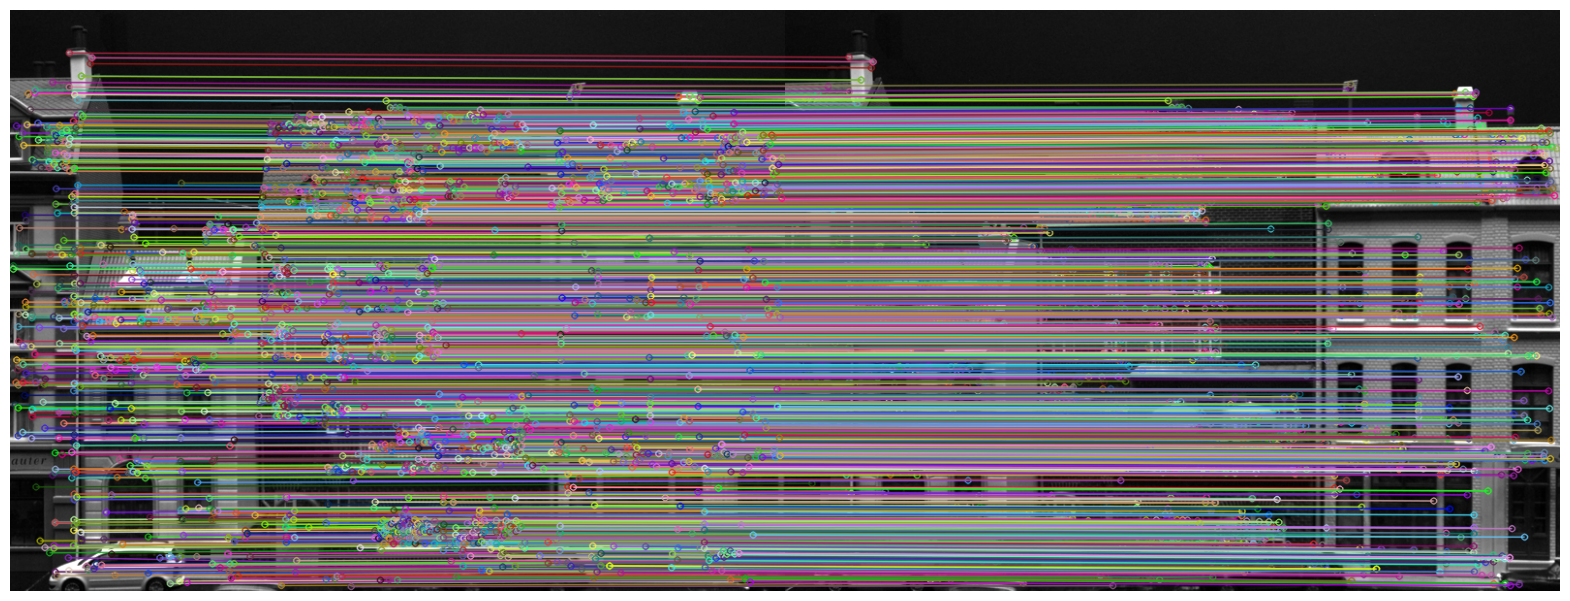

In [91]:
good = [match for match in matches if match != ()]
matches_masked = [match for match, mask in zip(good, inlier_mask) if mask]

im_sift2 = cv2.drawMatchesKnn(im1, kp1, im2, kp2, matches_masked, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)[:,:,::-1]

fig = plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(im_sift2)
plt.show()
